<a href="https://colab.research.google.com/github/gusujio/neural_networks_start/blob/master/%D0%BF%D0%B5%D1%80%D0%B2%D0%B0%D1%8F_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
len(y_train), len(y_test)

(60000, 10000)

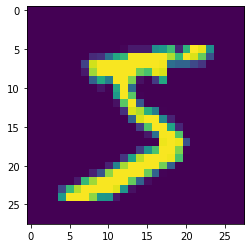

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Давайте видеоизменим LeNet чтобы повысить качество на валидации. У нас есть некоторые вещи которые неплохо было бы исправить. Например, активации: сейчас уже никто не использует активации тангенсами, потому что они приводят к затуханию градиента -- вы не можете построить действительно глубокую сеть, чтобы ваши ошибки, посчитанные и в конце сети хорошо прокидывались к началу сети. Тангенсы или сигмоиды приводят к тому, что у вас сигнал очень быстро затухает. Во-вторых сейчас мало кто использует свёртки 5 на 5. Практически все сети свёртки 5 на 5 заменяют на подряд идущие две свёртки 3 на 3. Почему так делается? Потому что в 5 на 5 -- 25 весов, как можно легко догадаться, а вот в двух свёртках 3 на 3 -- в одной свёртке 9 весов, и в другой 9 весов -- получается 18 весов. А, в принципе, тот объём многообразия, которое позволяет применение двух последовательных сверток, аналогичен одной свёртке 5 на 5. Весов меньше -- наверное, будет меньше переобучения. В-третьих у нас тут используется average pooling, но average pooling уже нигде не используется, кроме как в самом конце сети. Сейчас используются везде max pooling. Давайте это тоже поправим. И последний момент -- это батч-нормализация, которая призвана ускорять обучение. Кажется, тут её тоже логично применить. Давайте все эти пункты мы возьмём и попробуем.

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
# И на вход нужно передать num_features, то есть то количество каналов,
#  которое имеет картинка или тензор перед батч-нормализацией.
        self.bn1 = torch.nn.BatchNorm2d(num_features=6) 
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function    

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x                

Единственный момент, который мы должны не забыть добавить в процесс обучения, связанный тоже с батч-нормализацией -- это некоторый флажок: либо сеть находится в состоянии тренировки (и, соответственно, мы должны проставить "net.train"), либо сеть находится в состоянии "evaluation", (который проставляется с помощью "net.eval"). Зачем это нужно? Пока мы не использовали батч-нормализацию, нам не нужно было проставлять эти флажки -- сеть находится в "train" режиме, или в "evaluation". Но дело в том, что батч-нормализация происходит не в момент вычисления градиентов (не в момент backward), а в момент forward. То есть каждый раз, когда мы проходим картинкой по сети в forward-направлении у нас заново обучаются/подгоняются параметры математического ожидания и стандартного отклонения в batch-norm слое. И, соответственно, чтобы этого не происходило, мы должны явно сказать batch-norm слою, что у нас сеть не обучается, а мы её тестируем, чтобы он не изменял эти параметры математического ожидания и стандартного отклонения. Иначе у нас будет сетка изменяться, когда мы это выпустим куда-то в продакшн. 

In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

# Мы запустим несколько экспериментов. Сперва мы заменим активизацию тангенс на ReLU. 
# Потом мы разобьём слой 5 на 5 на два слоя 3 на 3. 
# После этого мы изменим pooling -- скажем, что у нас теперь не average pooling,
#  а max pooling. И в конце мы добавим батч-нормализацию после двух конволюционных слоёв.

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)            

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

Мы видим, что обучилось 30 эпох. Синим графиком обозначен самый стандартный вариант. Он доходит до качества 0.99. В принципе, все графики примерно доходят до одинакового качества на валидации, что, скорее, говорит о том, что задача, в принципе, решена. Качество в 99.2% -- уже довольно хорошее. И далее нейросеть просто колеблется возле этой точки оптимума. Когда график accuracy не показателен, можно обратиться к графику лосс -- в данном случае у нас лосс -- это кросс-энтропия. Чем меньше значение кросс-энтропии -- тем лучше, мы его минимизировали. Синий график (который у нас "тангенс") -- он является не самым низким, то есть это не самое лучшее качество с точки зрения лосс-функции. Самое лучшее качество, наверняка, достигается с "relu_3", то есть конволюции 3 на 3 побеждают (немножко). И видно, что они не так сильно переобучаются: после десятой эпохи видно, что все графики немножко растут. Это говорит о том, что сеть начинает переобучаться, то есть запоминать наш датасет. И, так как у нас красный график идёт ниже, чем синий, в плане переобучения, то, наверное, именно то, что мы изменили конволюцию с 5 на 5 на 3 на 3, и, соответственно, уменьшили количество весов, дало такой результат -- что сети сложнее переобучиться, подстроить веса под текущий, существующий датасет. Кроме того видно, что max pooling нам не принесли никакого результата. Они только ухудшают обучение, но не всегда результаты интуитивны. Конкретно для этой задачи, конкретно для этой сети происходит так. Кроме того, видно что батч-нормализация, которая призвана ускорять обучение, тут ничего не ускоряет. То есть у нас лосc -- как падал за две-три эпохи до минимума, так он и падает за две три эпохи до минимума. Но, наверное, тут дело в том, что мы довольно быстро выучиваем датасет, и что-то ускорять тут уже невозможно. Возможно, нам стоит взять более сложный датасет, где качество будет немножко похуже, и тогда мы посмотрим различие этих добавок -- насколько они действительно влияют на результат. Здесь разницы практически нет.

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [ ]:
def relu(x):
    if x > 0:
        return x
    return 0    

In [19]:
import math

In [25]:
print('w4',(1 - math.tanh(math.tanh(math.tanh(math.tanh(100))))**2)*math.tanh(math.tanh(math.tanh(100))))
print('w3',(1 - math.tanh(math.tanh(math.tanh(math.tanh(100))))**2)*(1-math.tanh(math.tanh(math.tanh(100)))**2)*math.tanh(math.tanh(100)))
print('w2',(1 - math.tanh(math.tanh(math.tanh(math.tanh(100))))**2)*(1-math.tanh(math.tanh(math.tanh(100)))**2)*(1-math.tanh(math.tanh(100))**2)*math.tanh(100))
print('w1',(1 - math.tanh(math.tanh(math.tanh(math.tanh(100))))**2)*(1 - math.tanh(math.tanh(math.tanh(100)))**2)*(1 - math.tanh(math.tanh(100))**2)*(1 - math.tanh(100)**2)*100)

w4 0.43614538244454387
w3 0.30412468309754653
w2 0.1677068587693903
w1 0.0
